### Import Packages and Data

In [167]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 1
warnings.filterwarnings("ignore")

import pandas_datareader.data as web
import datetime


import tensorflow as tf
import os
from tensorflow.keras import layers, models
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tools.eval_measures import rmse
import itertools

from sktime.forecasting.arima import AutoARIMA

In [79]:
# Get the WTI curde oil price data for the last twenty years, resample the data by month and rename the column
end_date = datetime.datetime(2022,12,31)
start_date = end_date-datetime.timedelta(days=365*20)

wti = web.DataReader('DCOILWTICO', 'fred', start_date, end_date)
wti=wti.resample('W').mean()
wti=wti.rename({'DCOILWTICO':'Price'}, axis=1)

In [80]:
wti.head()

,Price
DATE,
2003-01-12,31.538
2003-01-19,33.038
2003-01-26,34.455
2003-02-02,33.192
2003-02-09,33.954


### Visualize the data

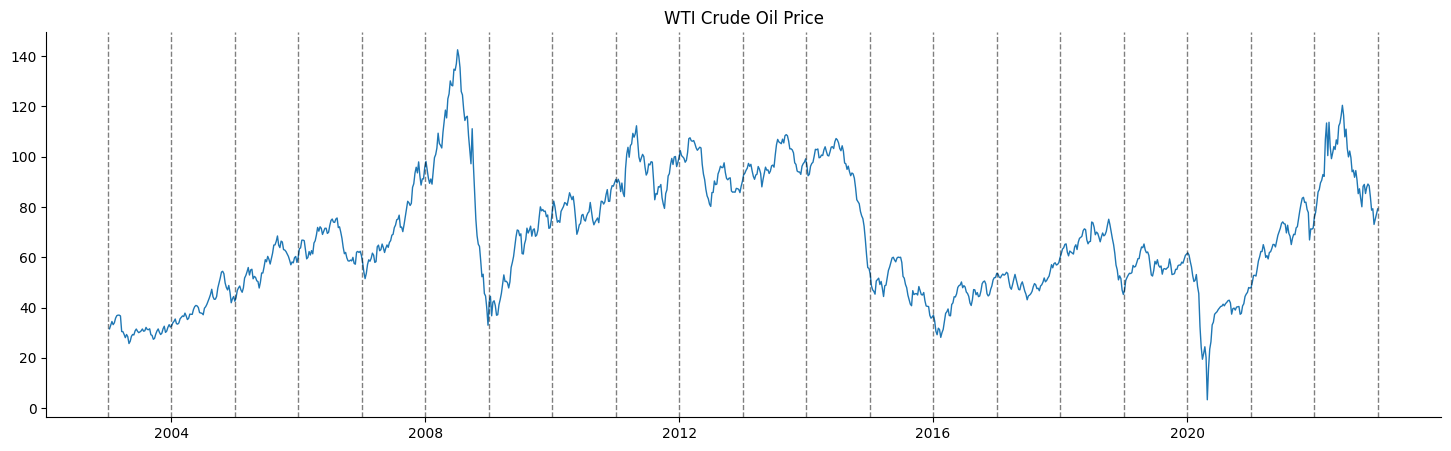

In [107]:
plt.plot(wti)
plt.title('WTI Crude Oil Price')

for year in list(set(wti.index.year)):
    plt.axvline(datetime.datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

### Seasonal Trend Decomposition using Loess

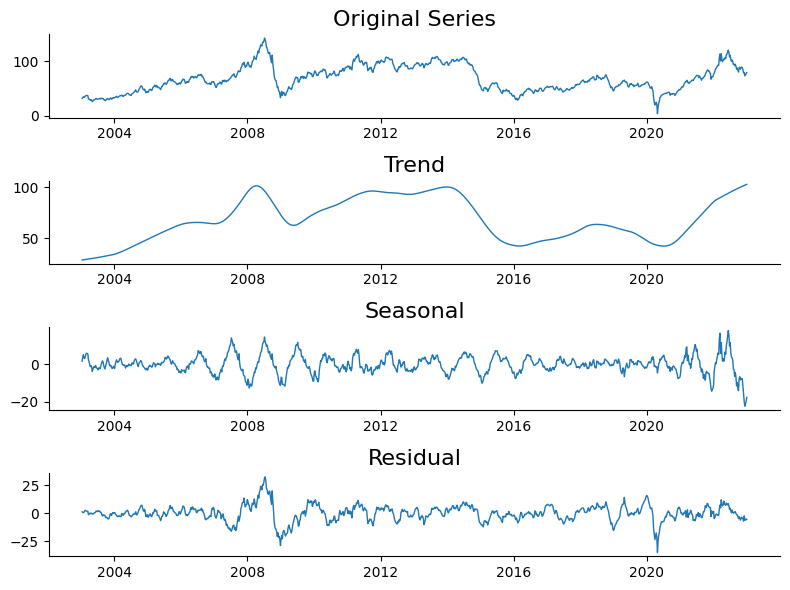

In [108]:
stl=STL(wti)
result=stl.fit()

seasonal, trend, resid = result.seasonal, result.trend, result.resid

plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(wti)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

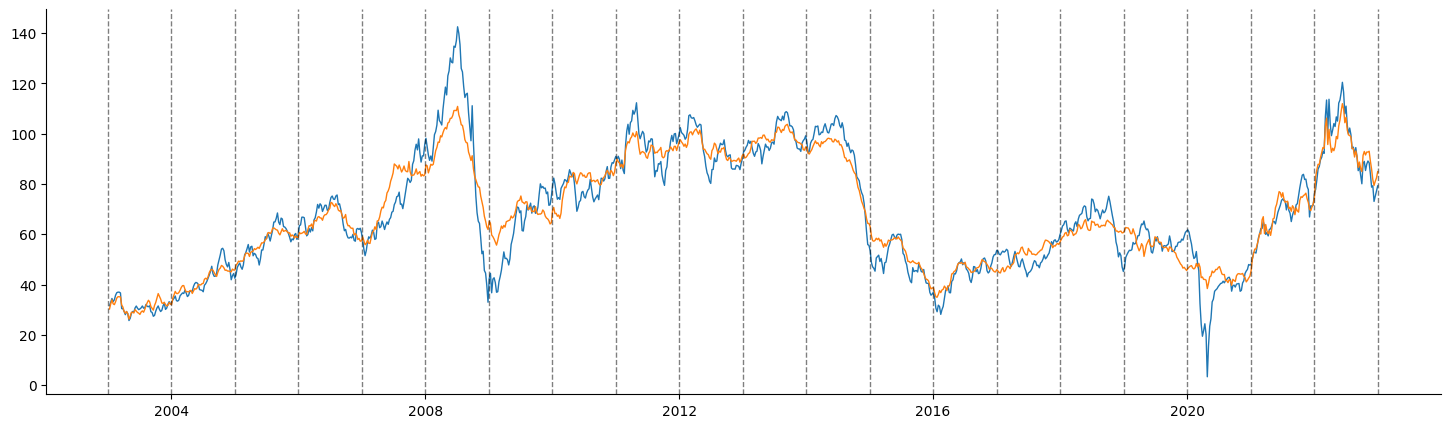

In [110]:
estimated=trend+seasonal
plt.plot(wti, label='Original')
plt.plot(estimated, label='Estimated')

for year in list(set(wti.index.year)):
    plt.axvline(datetime.datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

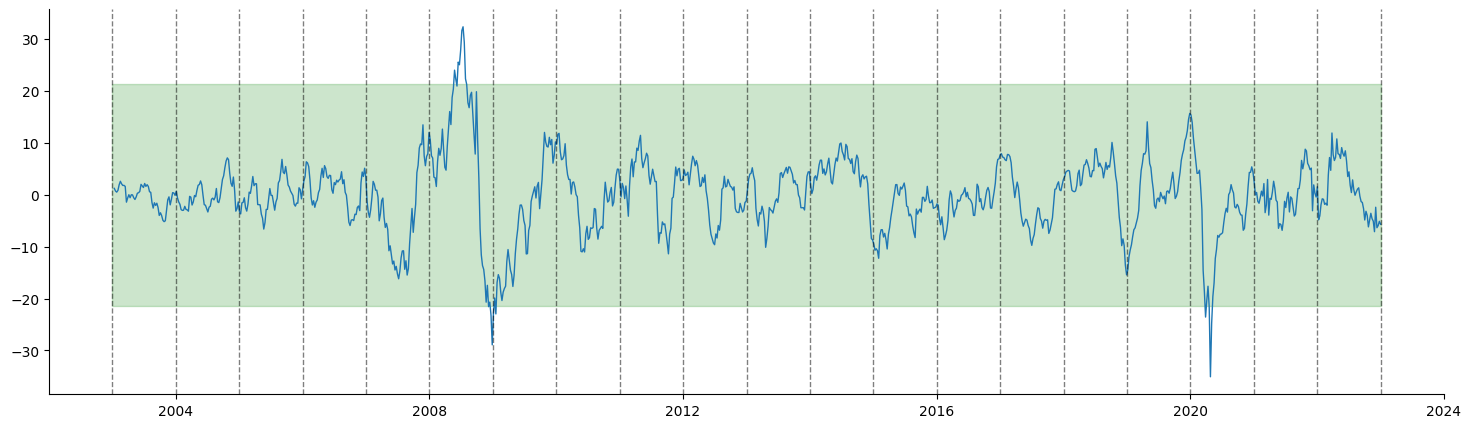

In [113]:
# Anomaly Detection
resid_mu=resid.mean()
resid_dev=resid.std()

lower=resid_mu-3*resid_dev
higher=resid_mu+3*resid_dev

plt.plot(resid)
plt.fill_between([datetime.datetime(2003,1,1),datetime.datetime(2023,1,1)],lower,higher,color='g',alpha=0.2)
for year in list(set(wti.index.year)):
    plt.axvline(datetime.datetime(year,1,1), color='k', linestyle='--', alpha=0.5)


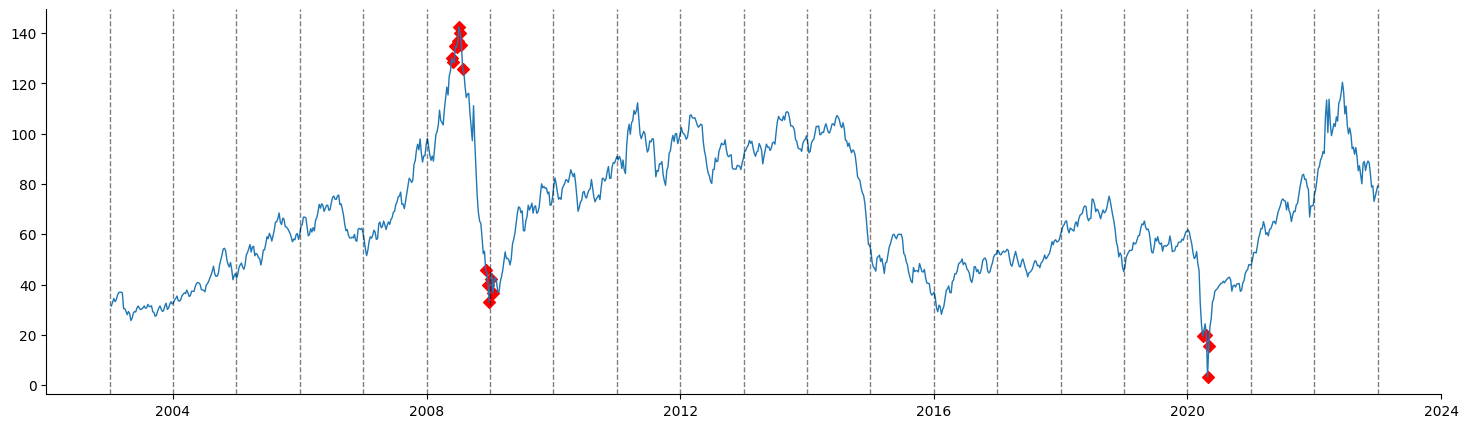

In [116]:
anomalies=wti[(resid<lower)|(resid>higher)]

plt.plot(wti)
for year in list(set(wti.index.year)):
    plt.axvline(datetime.datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
plt.scatter(anomalies.index, anomalies.Price, color='r', marker='D')

As we can see there are multiple outliers during 2008 to 2009 and 2020 to 2021, which are financial crisis and COVID-19 pandemic respectively

### Test stationarity

1. Why test for stationarity?
    * Stationary processes are easier to analyze
    * Most forecasting algorithms assume a series is stationary
2. One way to test if a TS is stationary is to plot the rolling mean and rolling standard deviation. If the TS is stationary, then the rolling mean and rolling standard deviation should be constant over time
3. Augmented Dicky-Fuller test, or ADF test is frequently used to determine whether a TS is stationary. It is actually a simple hypothesis testing where
    * Null hypothesis (H0) — Time series is not stationary
    * Alternative hypothesis (H1) — Time series is stationary
4. KPSS is another test for stationarity. It is also a hypothesis testing where
    * Null hypothesis (H0) — Time series is stationary
    * Alternative hypothesis (H1) — Time series is not stationary

In [82]:
def test_stationary(ts):
    # Dickey-Fuller test:
    adf_result=adfuller(ts)
    adf_p=adf_result[1]
    kpss_result=kpss(ts)
    kpss_p=kpss_result[1]
    
    if adf_p<0.05 and kpss_p>0.05:
        print('ADF test p-value: ', adf_p,' | ', 'KPSS test p-value: ', kpss_p)
        print('The series is stationary')
    else:
        print('ADF test p-value: ', adf_p,' | ', 'KPSS test p-value: ', kpss_p)
        print('The series is non-stationary')
    

In [83]:
test_stationary(wti['Price'])

ADF test p-value:  0.018683994890522054  |  KPSS test p-value:  0.03996956910658508
The series is non-stationary


### Transformation

As the TS is not stationary, we need to transform it to make it stationary. There are two common ways to do this, which are through differencing and log transformation. We will use both of them and compare the results.

#### Differencing

In [84]:
wti_1diff=(wti['Price']-wti['Price'].shift(1)).dropna()

In [85]:
test_stationary(wti_1diff)

ADF test p-value:  1.7150342785697865e-10  |  KPSS test p-value:  0.1
The series is stationary


Text(0.5, 1.0, 'First Difference of WTI Crude Oil Price')

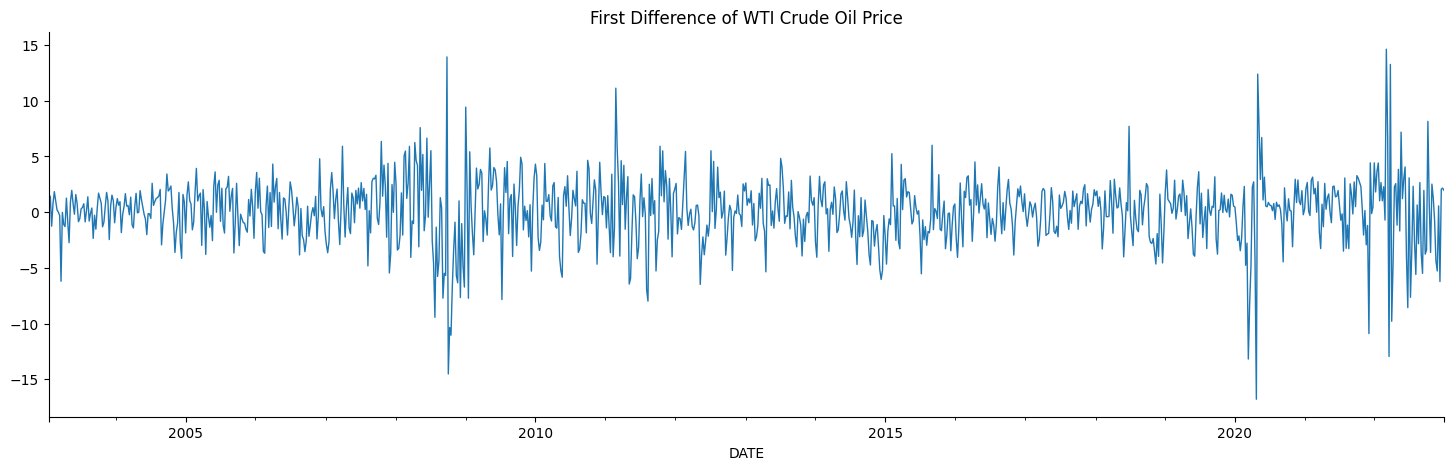

In [87]:
wti_1diff.plot()
plt.title('First Difference of WTI Crude Oil Price')

#### Log Transformation

In [88]:
wti_log=np.log(wti['Price'])

In [89]:
test_stationary(wti_log)

ADF test p-value:  0.015809637007567122  |  KPSS test p-value:  0.0361898519324249
The series is non-stationary


In [90]:
# As log transformation does not make the series stationary, we will use the first difference of the series
wti_log_diff=(wti_log-wti_log.shift(1)).dropna()

In [91]:
test_stationary(wti_log_diff)

ADF test p-value:  1.2843363588772687e-26  |  KPSS test p-value:  0.1
The series is stationary


<Axes: xlabel='DATE'>

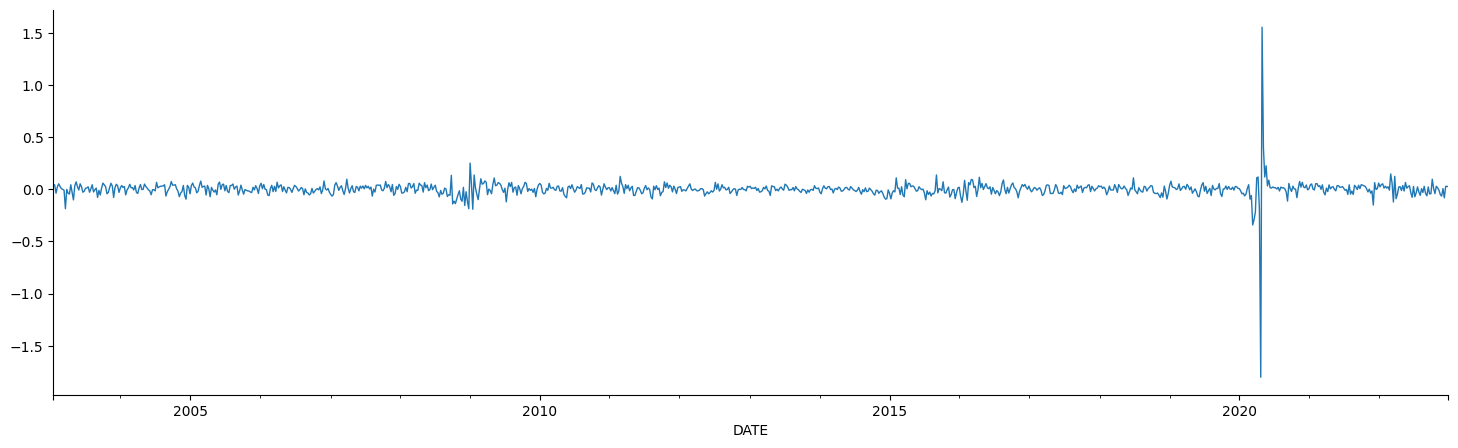

In [92]:
wti_log_diff.plot()

As the p-value of ADF test of wti_log_diff is lower than that of wti_1diff, wti_log_diff is a better choice in terms of stationarity, we would choose wti_log_diff for the modeling part.

### Modeling

In [118]:
len(wti_log_diff)/20

52.1

#### Train test split

In [143]:
train_size=int(len(wti_log)*0.8)
train,test=wti_log[0:train_size], wti_log[train_size:len(wti_log_diff)]

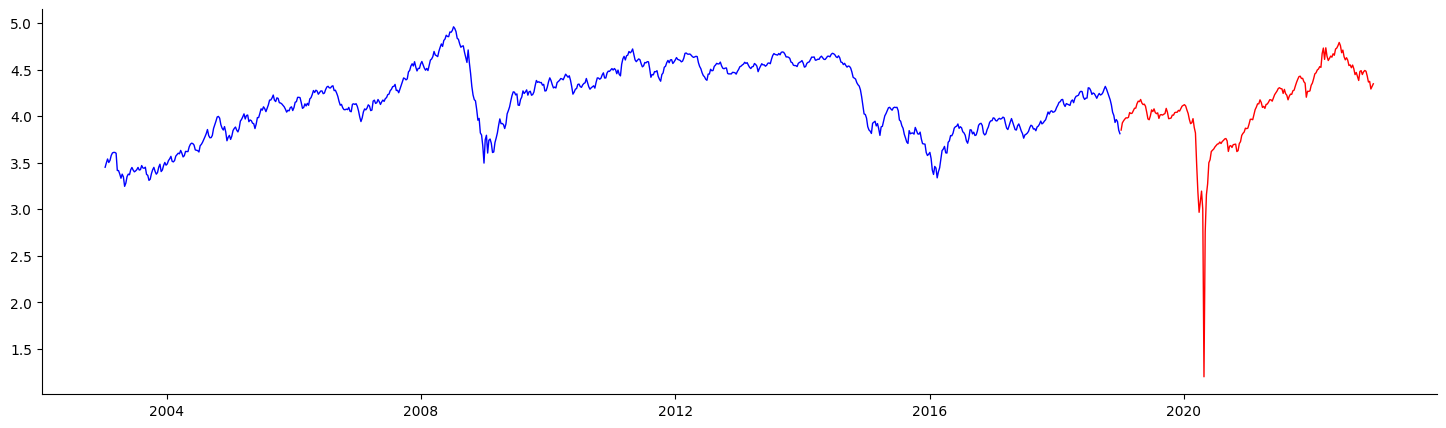

In [144]:
plt.plot(train, label='Train',color='b')
plt.plot(test, label='Test',color='r')

#### ARIMA

1. ARIMA models (which include ARMA, AR and MA models) are a general class of models to forecast stationary time series. ARIMA models are made of three parts:
    * p: the number of autoregressive terms (AR part)
    * d: the number of nonseasonal differences needed for stationarity
    * q: the number of lagged forecast errors in the prediction equation (MA part)
2. Choosing the order d
    * I take first differecing to make the ts stationary, so d = 1
3. Choosing the order p
    * We can use PACF to determine the order p
    * Look for a significant spike at lag k in the PACG, it there is one, then suggests that an AR(k) model may be appropriate
4. Choosing the order q
    * We can use ACF to determine the order q
    * Look for a significant spike at lag k in the ACF, it there is one, then suggests that an MA(k) model may be appropriate

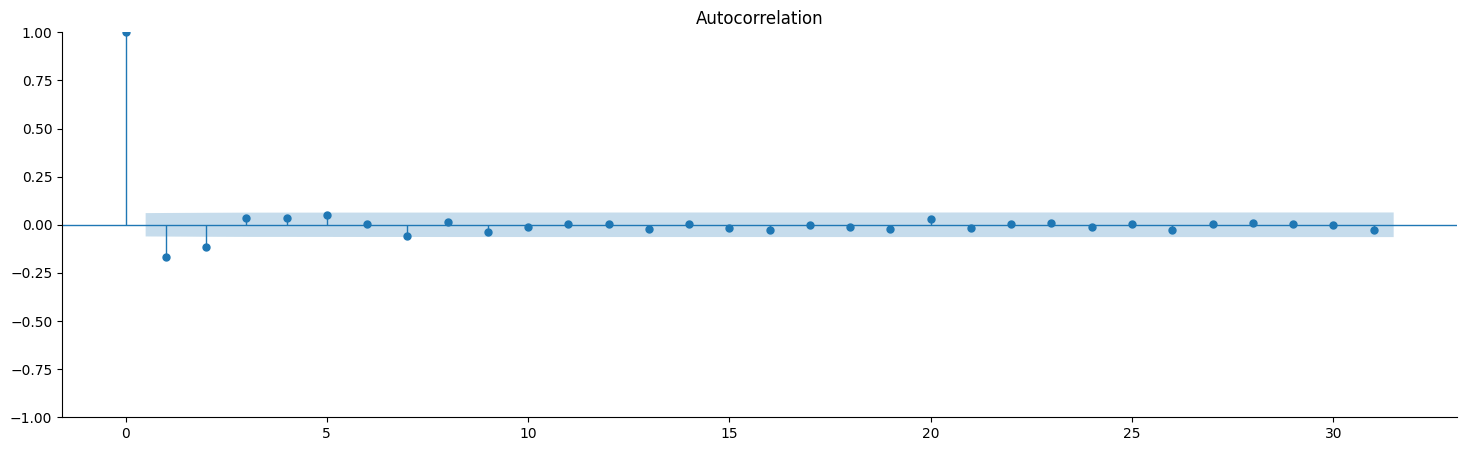

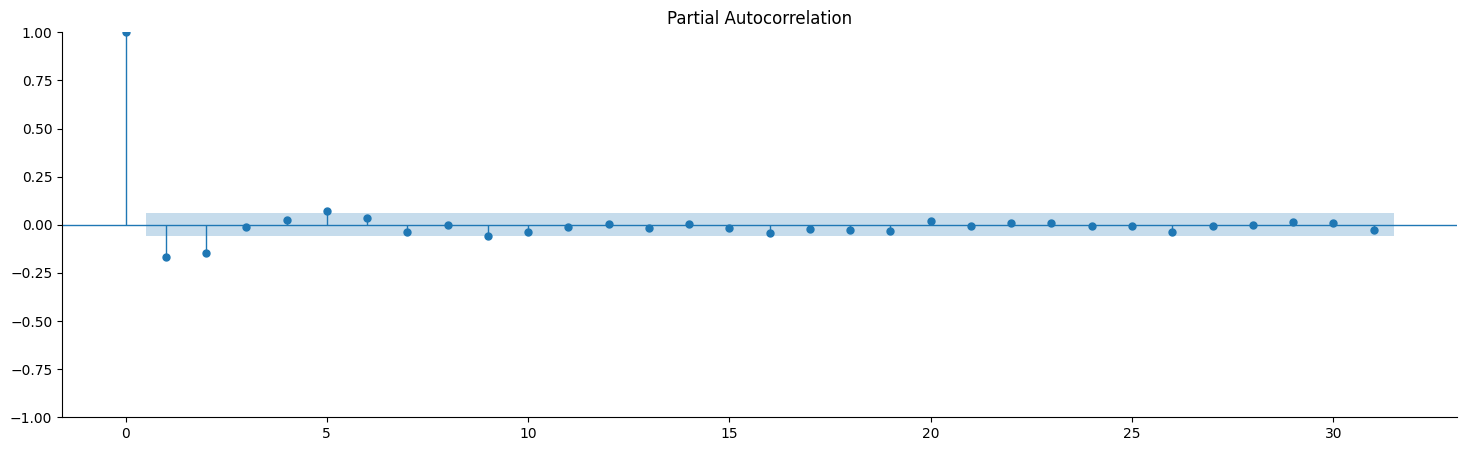

In [145]:
plot_acf(wti_log_diff);
plot_pacf(wti_log_diff);

Based on PACF and ACF, one of the combination of p=(1,2) and q=(1,2) could be the best choice, I will use grid search to find the best combination.

In [146]:
p=[1,2]
d=[1]
q=[1,2]

param_combinations=list(itertools.product(p,d,q))

best_model=None
best_aic=np.inf

def arima_aic(params, ts):
    try:
        model=ARIMA(ts, order=params)
        result=model.fit()
        return result.aic
    except:
        return np.nan

for params in param_combinations:
    aic=arima_aic(params, train)
    if np.isnan(aic):
        continue
    if aic<best_aic:
        best_aic=aic
        best_model=params

print("Best (p,d,q) combination: ", best_model)
print("Best AIC: ", best_aic)
      
        

Best (p,d,q) combination:  (2, 1, 2)
Best AIC:  -2968.73572479883


In [161]:
model=ARIMA(train,order=best_model)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  834
Model:                 ARIMA(2, 1, 2)   Log Likelihood                1489.368
Date:                Fri, 03 Mar 2023   AIC                          -2968.736
Time:                        16:28:45   BIC                          -2945.111
Sample:                    01-12-2003   HQIC                         -2959.677
                         - 12-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3211      0.123      2.619      0.009       0.081       0.561
ar.L2          0.4692      0.087      5.387      0.000       0.298       0.640
ma.L1         -0.1010      0.126     -0.801      0.423      -0.348       0.146
ma.L2         -0.5800      0.083     -6.970      0.000      -0.743      -0.417
sigma2         0.0016   5.27e-05     31.069      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               683.73
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.11
Prob(H) (two-sided):                  0.95   Kurtosis:                         7.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

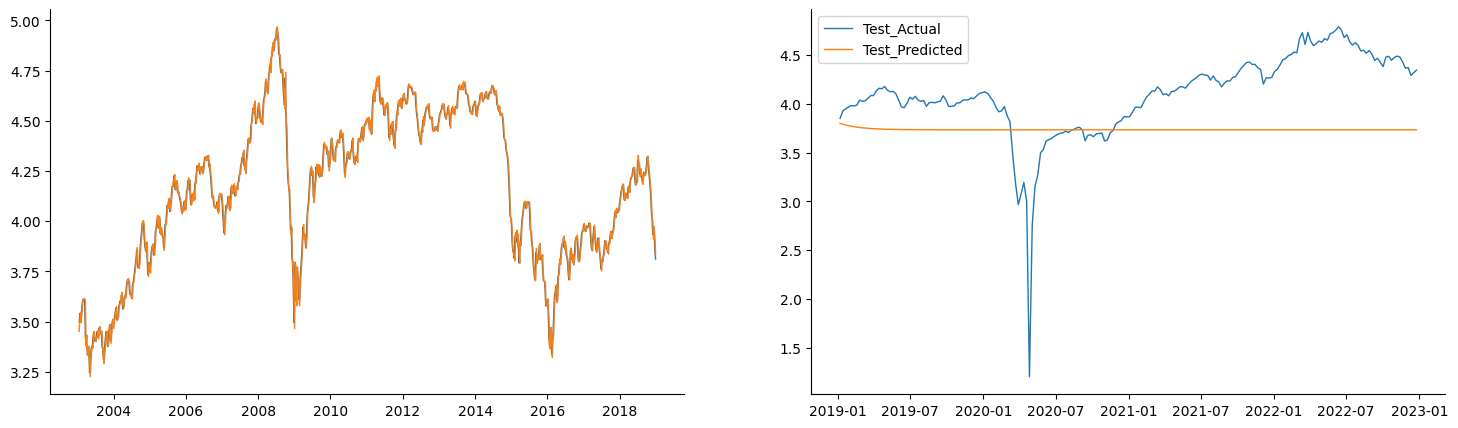

In [166]:
train_predicted=pd.Series(result.fittedvalues, copy=True)

start_idx=len(train)
end_idx=start_idx+len(test)-1

test_predicted=result.predict(start=start_idx, end=end_idx)

fig,ax=plt.subplots(1,2)

ax[0].plot(train[1:],label='Train_Actual')
ax[0].plot(train_predicted[1:],label='Train_Predicted')

ax[1].plot(test,label='Test_Actual')
ax[1].plot(test_predicted,label='Test_Predicted')

plt.legend()
plt.show()

In [ ]:
mse=np.mean((predictions-test)**2)
print("Test MSE: ", mse)

NotImplementedError: 

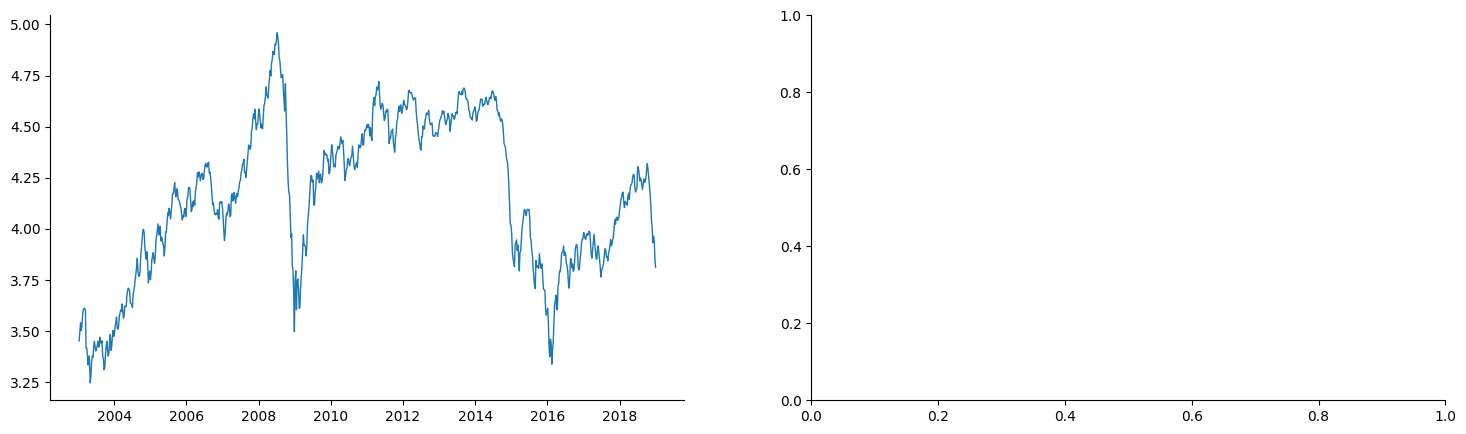

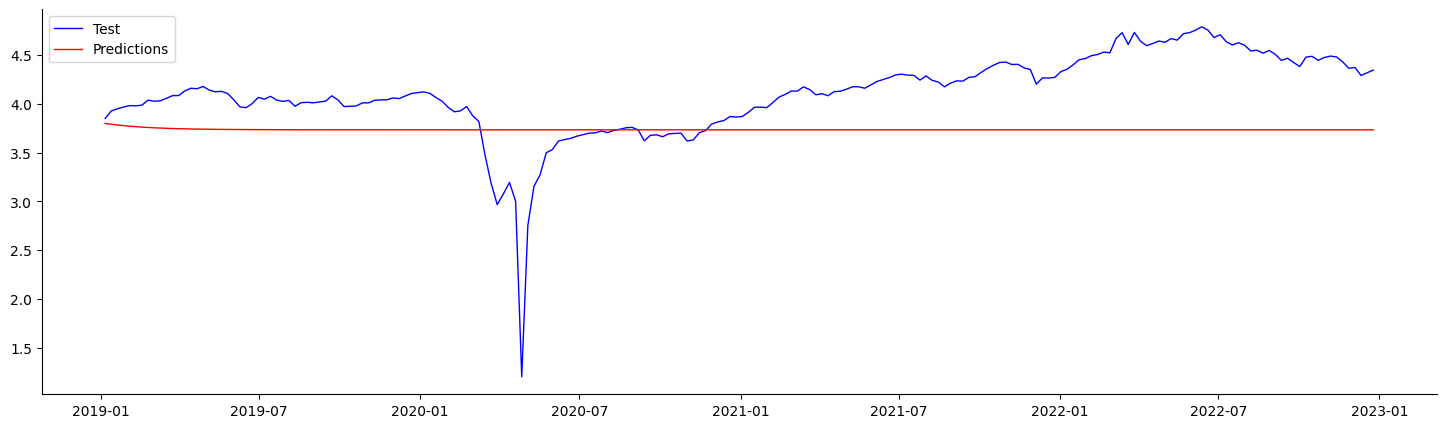

In [148]:
plt.plot(test, label='Test', color='b')
plt.plot(predictions, label='Predictions', color='r')
plt.legend()

In [142]:
test

DATE
2019-01-06    0.038463
2019-01-13    0.077426
2019-01-20    0.022279
2019-01-27    0.018150
2019-02-03    0.014253
                ...   
2022-12-04    0.007018
2022-12-11   -0.081801
2022-12-18    0.027804
2022-12-25    0.028269
2023-01-01    0.024977
Freq: W-SUN, Name: Price, Length: 209, dtype: float64

In [141]:
np.cumsum(predictions)

2019-01-06   -0.002252
2019-01-13   -0.001865
2019-01-20   -0.002677
2019-01-27   -0.002944
2019-02-03   -0.003460
                ...   
2022-12-04   -0.090959
2022-12-11   -0.091396
2022-12-18   -0.091834
2022-12-25   -0.092271
2023-01-01   -0.092709
Freq: W-SUN, Name: predicted_mean, Length: 209, dtype: float64

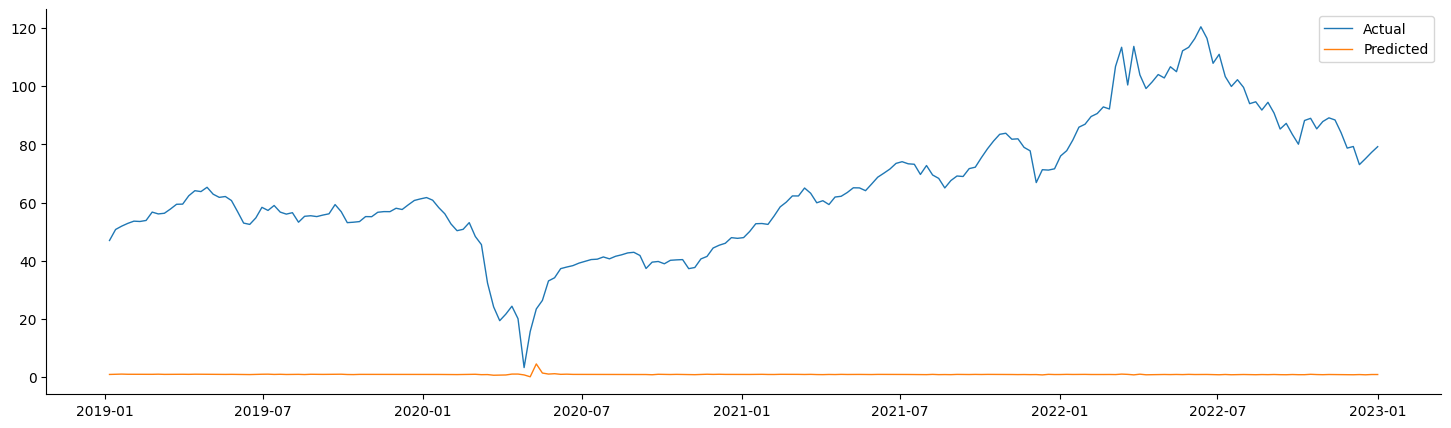

In [139]:
prediction_reversed_diff=np.cumsum(predictions)+wti_log_diff.shift(1)[-len(predictions):]
prediction_reversed_log=np.exp(prediction_reversed_diff)
wti_pred=prediction_reversed_log
wti_test=wti.loc[list(test.index),'Price']

plt.plot(wti_test.index, wti_test.values, label='Actual')
plt.plot(wti_pred.index, wti_pred.values, label='Predicted')
plt.legend()
plt.show()